In [292]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

Read in and describe the data, with some quick visualisations.

In [293]:
hp = pd.read_csv("~/HW2/train.csv")
kaggle = pd.read_csv("~/HW2/test.csv")
#drop ids
hp.drop("Id", axis = 1, inplace = True)
kaggle.drop("Id", axis = 1, inplace = True)

In [294]:
kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 non

None of the variables that have missing data seem essential, so I will drop those. This is an especially easy decision in this case because we have good proxies for the data we will be deleting (e.g. TotalBsmtSf for BsmtCond)

In [295]:
hp = hp.dropna(axis = 'columns')
hp.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'MSZoning', 'Utilities','Exterior1st', 'Exterior2nd', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'SaleType'], axis = 1, inplace = True)
#kaggle.drop('Electrical', axis = 1, inplace = True)
#Fill the one missing value of TotalBsmtSF, GarageArea, and GarageCars with 0
kaggle['TotalBsmtSF'] = kaggle['TotalBsmtSF'].fillna(0)
kaggle['GarageArea'] = kaggle['GarageArea'].fillna(0)
kaggle['GarageCars'] = kaggle['GarageCars'].fillna(0)
kaggle = kaggle.dropna(axis = 'columns')
kaggle['TotalBsmtSF'] = kaggle['TotalBsmtSF'].astype('int64')
kaggle['GarageArea'] = kaggle['GarageArea'].astype('int64')
kaggle['GarageCars'] = kaggle['GarageCars'].astype('int64')

Add in total square feet and ratio of total square feet to lot area as variables.

In [296]:
hp['TotalSqFt'] = hp['TotalBsmtSF'] + hp['1stFlrSF'] + hp['2ndFlrSF']
hp['TSqFt_LA'] = hp['TotalSqFt'] / hp['LotArea']
kaggle['TotalSqFt'] = kaggle['TotalBsmtSF'] + kaggle['1stFlrSF'] + kaggle['2ndFlrSF']

Look at the relationship between total square feet and sale price.

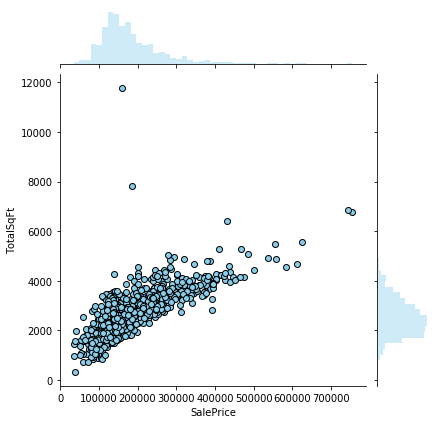

In [297]:
sns.jointplot(x = hp['SalePrice'], y = hp['TotalSqFt'], color = 'skyblue', edgecolor = 'black')

Look at relationship between ratio of total square feet to lot area and sale price.

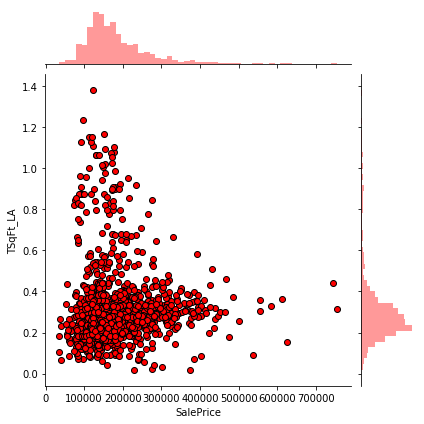

In [298]:
sns.jointplot(x = hp['SalePrice'], y = hp['TSqFt_LA'], color = 'red', edgecolor = 'black')

We can see in both of the above graphs that SalePrice is not distributed normally. We will use the natural log of SalePrice to compensate for this. This means that error at any point in the distribution of prices will affect our total error equally. Also, we'll remove any houses over 6,000 sqft as outliers.

In [299]:
hp['SalePrice'] = np.log(hp['SalePrice'])
hp = hp[hp.TotalSqFt < 6000]

Create a covariance matrix for quantitative variables to see which ones can be excluded due to high correlation with other variables.

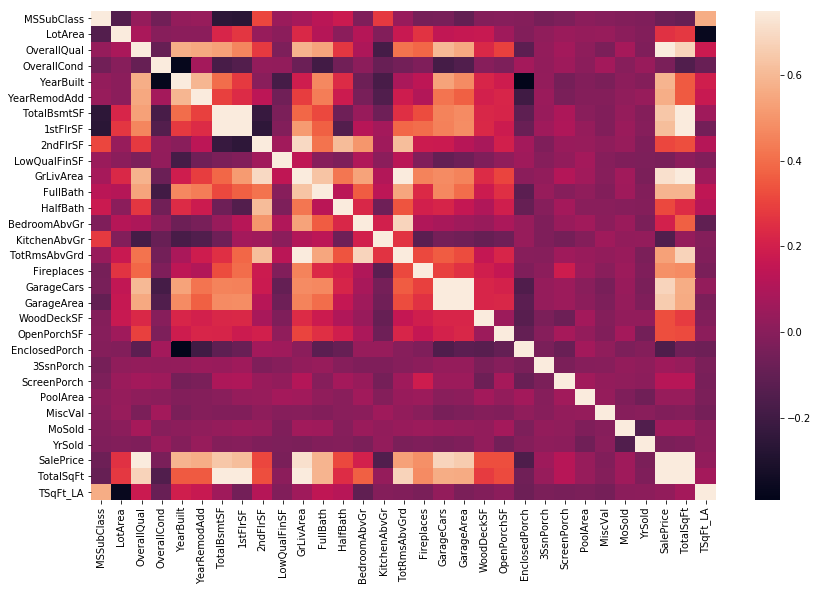

In [300]:
cov_matrix = hp.corr()
f, ax = plt.pyplot.subplots(figsize = (14,9))
sns.heatmap(cov_matrix, vmax = .75, square = False)

We can then take a look into the covariance matrix to see which features are significantly correlated with the sale price.

In [301]:
cov_matrix['SalePrice'].sort_values(ascending = False)

SalePrice        1.000000
TotalSqFt        0.822638
OverallQual      0.819107
GrLivArea        0.717513
GarageCars       0.681258
GarageArea       0.655958
TotalBsmtSF      0.640224
1stFlrSF         0.612351
FullBath         0.589150
YearBuilt        0.589103
YearRemodAdd     0.569491
TotRmsAbvGrd     0.531782
Fireplaces       0.487146
WoodDeckSF       0.329192
OpenPorchSF      0.326981
HalfBath         0.313123
2ndFlrSF         0.308596
LotArea          0.259087
BedroomAbvGr     0.202357
ScreenPorch      0.124556
MoSold           0.063172
3SsnPorch        0.056369
PoolArea         0.040855
TSqFt_LA         0.024138
MiscVal         -0.019646
YrSold          -0.033376
OverallCond     -0.036065
LowQualFinSF    -0.037574
MSSubClass      -0.073812
KitchenAbvGr    -0.147836
EnclosedPorch   -0.157242
Name: SalePrice, dtype: float64

Looks like TSqFt_LA actually has little effect on SalePrice.

In [302]:
hp.drop('TSqFt_LA', axis = 1, inplace = True)

Next, we'll add in a few polynomial variables for the most relevant quantitative variables.

In [303]:
hp['OverallQualE2'] = hp['OverallQual'] ** 2
hp['OverallQualE3'] = hp['OverallQual'] ** 3
hp['OverallQualR2'] = np.sqrt(hp['OverallQual'])
hp['TotalSqFtE2'] = hp['TotalSqFt'] ** 2
hp['TotalSqFtE3'] = hp['TotalSqFt'] ** 3
hp['TotalSqFtR2'] = np.sqrt(hp['TotalSqFt'])
hp['GrLivAreaE2'] = hp['GrLivArea'] ** 2
hp['GrLivAreaE3'] = hp['GrLivArea'] ** 3
hp['GrLivAreaR2'] = np.sqrt(hp['GrLivArea'])
hp['YearBuiltE2'] = hp['YearBuilt'] ** 2
hp['YearBuiltE3'] = hp['YearBuilt'] ** 3
hp['YearBuiltR2'] = np.sqrt(hp['YearBuilt'])
kaggle['OverallQualE2'] = kaggle['OverallQual'] ** 2
kaggle['OverallQualE3'] = kaggle['OverallQual'] ** 3
kaggle['OverallQualR2'] = np.sqrt(kaggle['OverallQual'])
kaggle['TotalSqFtE2'] = kaggle['TotalSqFt'] ** 2
kaggle['TotalSqFtE3'] = kaggle['TotalSqFt'] ** 3
kaggle['TotalSqFtR2'] = np.sqrt(kaggle['TotalSqFt'])
kaggle['GrLivAreaE2'] = kaggle['GrLivArea'] ** 2
kaggle['GrLivAreaE3'] = kaggle['GrLivArea'] ** 3
kaggle['GrLivAreaR2'] = np.sqrt(kaggle['GrLivArea'])
kaggle['YearBuiltE2'] = kaggle['YearBuilt'] ** 2
kaggle['YearBuiltE3'] = kaggle['YearBuilt'] ** 3
kaggle['YearBuiltR2'] = np.sqrt(kaggle['YearBuilt'])

We'll create dummy variables for all of our categorical variables.

In [304]:
complete = pd.concat([hp,kaggle])
complete = pd.get_dummies(complete)

/home/thecheat/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [305]:
hp = complete.iloc[0:1454]
kaggle = complete.iloc[1455:2941]

In [306]:
kaggle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Columns: 169 entries, 1stFlrSF to Street_Pave
dtypes: float64(5), int64(37), uint8(127)
memory usage: 671.1 KB


In [307]:
hp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1458
Columns: 169 entries, 1stFlrSF to Street_Pave
dtypes: float64(5), int64(37), uint8(127)
memory usage: 668.8 KB


In [308]:
train, dev = np.split(hp.sample(frac = 1), [int(.8*len(hp))])

In [309]:
y_train = train['SalePrice']
y_dev = dev['SalePrice']
train.drop('SalePrice', axis = 1, inplace = True)
dev.drop('SalePrice', axis = 1, inplace = True)

In [310]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train)
X_dev = scaler.transform(dev)

/home/thecheat/.miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/thecheat/.miniconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/thecheat/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [311]:
train_model = SGDRegressor(tol = .0001, eta0 = .003)
train_model.fit(X_train, y_train)
dev_pred = train_model.predict(X_dev)
train_pred = train_model.predict(X_train)
mse_dev = mean_squared_error(y_dev, dev_pred)
mse_train = mean_squared_error(y_train, train_pred)
print("RMSE on dev set: {}".format(np.sqrt(mse_dev)))
print("RMSE on training set: {}".format(np.sqrt(mse_train)))

RMSE on dev set: 0.13607785513864634
RMSE on training set: 0.10681075686108696


We can then look at each of the coefficients to determine which were the most relevant and impactful in determining our predictions.

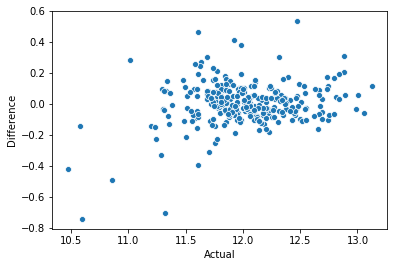

In [312]:
#sns.jointplot(x = hp['SalePrice'], y = hp['TSqFt_LA'], color = 'red', edgecolor = 'black')
results = pd.concat([y_dev.reset_index(), pd.Series(dev_pred)], axis = 1)
results.columns = ['Index', 'Actual', 'Predicted']
results['Difference'] = results['Actual'] - results['Predicted']
sns.scatterplot(x = 'Actual', y = 'Difference', data = results)

In [313]:
#submission = pd.DataFrame(np.exp(submit_pred), columns = ['SalePrice'])
#submission = pd.concat([hp_test['Id'], submission], axis = 1)
#submission

Then we create the file for submission.

In [314]:
X_kaggle = scaler.transform(kaggle)
#kaggle_pred = train_model.predict(X_kaggle)
#submission.to_csv("sub1.csv", sep=',')

/home/thecheat/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


ValueError: operands could not be broadcast together with shapes (1459,169) (168,) (1459,169) 